In [154]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import itertools
import powerlaw
import math
import warnings
import geopandas as gpd
warnings.filterwarnings('ignore')

### Funciones Auxiliares

In [376]:
def PageRank_Sort (Gm, directed, weight, name_at):
    Gm_pagerank = Gm.pagerank(vertices=None, directed=directed, 
             damping=0.85, weights=weight, arpack_options=None, 
             implementation='prpack')
    Gm_r=[]
    for i in range(len(Gm.vs)):
        Gm_r.append((Gm_pagerank[i],Gm.vs[i][name_at]))

    Gm_r.sort(reverse=True)
    return Gm_r

In [386]:
def Betweenness_Centrality_Sort (Gm, directed, weight, name_at):
    Gm.es["inv_weight"] = [10000/edge[weight] for edge in Gm.es]
    Gm_betweenness = Gm.betweenness(vertices=None, directed=directed, cutoff=None, weights='inv_weight')

    Gm_b=[]
    for i in range(len(Gm.vs)):
        Gm_b.append((Gm_betweenness[i],Gm.vs[i][name_at]))
    
    Gm_b.sort(reverse=True)
    return Gm_b

In [387]:
def Calcular_descriptivas(Gm, directed):
    
    Gm_strength = sum(Gm.strength(mode='all', loops=False, weights='weight'))
    if(directed == False): 
        Gm_strength = Gm_strength/2
    Gm_degree = Gm.ecount()
    Gm_density = Gm.density(loops=False)
    Gm_avg_shortest_path = Gm.average_path_length(directed=directed)
    Gm_total_vertices = Gm.vcount()
    Sending_nodes=len(Gm.vs.select(_outdegree_gt=0))/Gm_total_vertices*100
    Receiving_nodes = len(Gm.vs.select(_indegree_gt=0))/Gm_total_vertices*100
    Gm_tran = Gm.transitivity_undirected()
    Gm_lacc = Gm.transitivity_avglocal_undirected()
    tc= Gm.cliques(min=3,max=3)
    Gm_ntri = len(tc)

    tf=[]
    for i in range(len(Gm.vs)):
        n=0
        for t in tc:
            if i in t:
                n+=1
        tf.append(n)
    Gm_atri = np.mean(tf)
    
    G_properties = pd.DataFrame(
    {'Variable': ["Total vertices", 
                  "Sending nodes",
                  "Receiving nodes",
                  "Degree", 
                  "Connection density",
                  "Strength",
                  "Avg. path length",
                  'Number of triangles',
                  'Average triangles formed by an edge',
                  'Local average clustering coefficient',
                  'Transitivity'
                 ],
     'Value': [Gm_total_vertices,
               Sending_nodes, 
               Receiving_nodes,
               Gm_degree,
               Gm_density,
               Gm_strength,
               Gm_avg_shortest_path,
               Gm_ntri,
               Gm_atri,
               Gm_lacc,
               Gm_tran
              ],
    })

    return G_properties


In [388]:
def Calcular_relevancia (Gm, directed, weight, name_at):
    Gm_r = PageRank_Sort (Gm, directed, weight, name_at)
    Gm_b = Betweenness_Centrality_Sort (Gm, directed, weight, name_at)
    return Gm_b, Gm_r

### Función Principal

In [389]:
def Calcular_medidas (Gm, directed, weight, name_at):
    G_properties = Calcular_descriptivas(Gm, directed)
    Gm_b, Gm_r = Calcular_relevancia(Gm, directed, weight, name_at)
    return G_properties, Gm_b, Gm_r

### Pruebas 

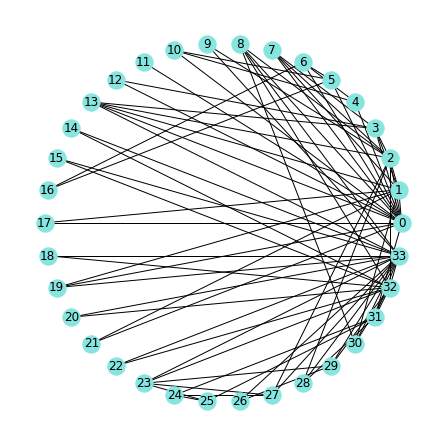

In [390]:
import matplotlib.pyplot as plt
import networkx as nx

cType =  'kar'

G = nx.karate_club_graph()
    
plt.figure(3,figsize=(6,6)) 
nx.draw_circular(G, with_labels=True, node_color ='#87E5DF')

plt.show()

nEdges=G.number_of_edges()
nNodes=G.number_of_nodes()

Gm = ig.Graph.from_networkx(G)
directed=False
weight='weight'
name_at="_nx_name"

Gm.es['weight']=[i+1 for i in range(Gm.ecount())]

In [391]:
G_properties = Calcular_descriptivas(Gm, False)
G_properties

,Variable,Value
0,Total vertices,34.000000
1,Sending nodes,100.000000
2,Receiving nodes,100.000000
3,Degree,78.000000
4,Connection density,0.139037
5,Strength,3081.000000
6,Avg. path length,2.408200
7,Number of triangles,45.000000
8,Average triangles formed by an edge,3.970588
9,Local average clustering coefficient,0.587931


In [397]:
Gm_b, Gm_r = Calcular_relevancia (Gm, directed, weight, 
                                  name_at)

In [398]:
Gm_b[:5]

[(309.0, 33), (167.0, 31), (167.0, 0), (117.0, 10), (60.0, 5)]

In [399]:
Gm_r[:5]

[(0.13101413694378344, 33),
 (0.08701433826717193, 32),
 (0.047849104971227484, 31),
 (0.04037963737427098, 2),
 (0.037455139611450604, 23)]

In [403]:
G_properties, Gm_b, Gm_r = Calcular_medidas (Gm, directed,
                                             weight, name_at)

In [404]:
Gm_b[:5]

[(309.0, 33), (167.0, 31), (167.0, 0), (117.0, 10), (60.0, 5)]

In [405]:
Gm_r[:5]

[(0.13101413694378344, 33),
 (0.08701433826717193, 32),
 (0.047849104971227484, 31),
 (0.04037963737427098, 2),
 (0.037455139611450604, 23)]

### Medidas Finales

#### Funciones para visualización

In [406]:
def Leer_mapa(uMapLevel):
    fp = uMapLevel
    gdf = gpd.read_file(fp)
    gdf = gdf.set_geometry("geometry")
    gdf = gdf.to_crs("EPSG:4326")
    return gdf

In [407]:
def Dibujar_mapa(gdf, labels, med, level):
    # Asignar el grupo a cada elemento del geo-dataframe
    for i in labels:
        if(level=="dep"):
            gdf.loc[gdf.IDDPTO==i[1],'GRUPO']=i[0]
        elif(level=="pro"):
            gdf.loc[gdf.IDPROV==i[1],'GRUPO']=i[0]
        elif(level=="dis"):
            gdf.loc[gdf.IDDIST==i[1],'GRUPO']=i[0]
    # Pintar el Perú según los grupos
    plt.figure(3,figsize=(8,8)) 
    gdf.plot("GRUPO",legend=True, figsize=(9,10))
    plt.savefig('Figures/Medidas_{}_{}.png'.format(med,level))

#### Departamentos

In [431]:
cType =  "dep"
Gm = ig.Graph.Read_Pajek("Input/grafoPeruDepartamentos.net")
directed=True
weight='weight'
name_at="name"

In [432]:
G_properties_dep, Gm_b_dep, Gm_r_dep = Calcular_medidas (Gm, directed,
                                             weight, name_at)

In [433]:
G_properties_dep.to_csv('Output/G_properties_{}.csv'.format(cType),
                    header=False)
G_properties_dep

,Variable,Value
0,Total vertices,2.500000e+01
1,Sending nodes,1.000000e+02
2,Receiving nodes,1.000000e+02
3,Degree,5.490000e+02
4,Connection density,9.150000e-01
5,Strength,1.050905e+08
6,Avg. path length,1.085000e+00
7,Number of triangles,2.032000e+03
8,Average triangles formed by an edge,2.438400e+02
9,Local average clustering coefficient,9.642328e-01


In [434]:
int(G_properties_dep.loc[G_properties_dep['Variable']=='Total vertices']['Value'])*5/100

1.25

In [435]:
Gm_b_dep[:5]

[(550.0, '15'), (23.0, '12'), (0.0, '25'), (0.0, '24'), (0.0, '23')]

In [466]:
Gm_r_dep[:5]

[(0.27666940024488085, '15'),
 (0.08257182056641006, '08'),
 (0.08066191903900806, '13'),
 (0.0698586676222245, '23'),
 (0.06198610010072766, '24')]

In [437]:
cType =  'dep'
uMapLevel="Input/departamentos/DEPARTAMENTOS.shp"
gdf = Leer_mapa(uMapLevel)

<Figure size 576x576 with 0 Axes>

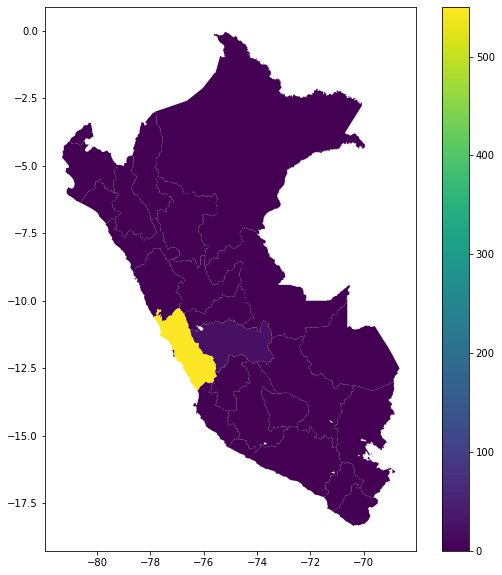

In [438]:
Dibujar_mapa(gdf, Gm_b_dep,'Cb', cType)

<Figure size 576x576 with 0 Axes>

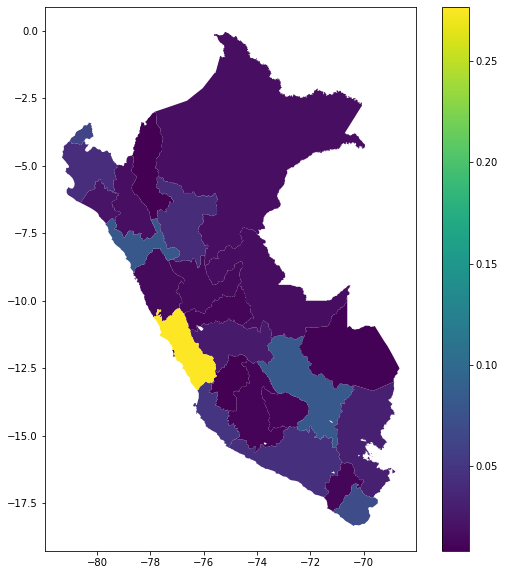

In [439]:
Dibujar_mapa(gdf, Gm_r_dep,'Cpr', cType)

#### Provincias

In [440]:
cType =  'pro'
Gm = ig.Graph.Read_Pajek("Input/grafoPeruProvincias.net")
directed=True
weight='weight'
name_at="name"


In [441]:
G_properties_pro, Gm_b_pro, Gm_r_pro = Calcular_medidas (Gm, directed,
                                             weight, name_at)

In [442]:
G_properties_pro.to_csv('Output/G_properties_{}.csv'.format(cType),
                    header=False)
G_properties_pro

,Variable,Value
0,Total vertices,1.890000e+02
1,Sending nodes,9.894180e+01
2,Receiving nodes,5.820106e+01
3,Degree,3.417000e+03
4,Connection density,9.616684e-02
5,Strength,1.095800e+08
6,Avg. path length,1.885006e+00
7,Number of triangles,2.411000e+04
8,Average triangles formed by an edge,3.826984e+02
9,Local average clustering coefficient,8.533667e-01


In [443]:
G_properties_pro

,Variable,Value
0,Total vertices,1.890000e+02
1,Sending nodes,9.894180e+01
2,Receiving nodes,5.820106e+01
3,Degree,3.417000e+03
4,Connection density,9.616684e-02
5,Strength,1.095800e+08
6,Avg. path length,1.885006e+00
7,Number of triangles,2.411000e+04
8,Average triangles formed by an edge,3.826984e+02
9,Local average clustering coefficient,8.533667e-01


In [444]:
int(G_properties_pro.loc[G_properties_pro['Variable']=='Total vertices']['Value'])*5/100

9.45

In [546]:
Gm_b_pro[:5]

[(19983.0, '1501'),
 (3295.0, '1301'),
 (1583.0, '0801'),
 (1117.0, '2501'),
 (978.0, '0201')]

In [494]:
Gm_r_pro[:5]

[(0.24472855777443098, '1501'),
 (0.07094077857686391, '1301'),
 (0.05866812032825353, '0801'),
 (0.05797572474250644, '2301'),
 (0.03898747879899255, '2401')]

In [447]:
cType =  'pro'
uMapLevel="Input/provincias/PROVINCIAS.shp"
gdf = Leer_mapa(uMapLevel)

<Figure size 576x576 with 0 Axes>

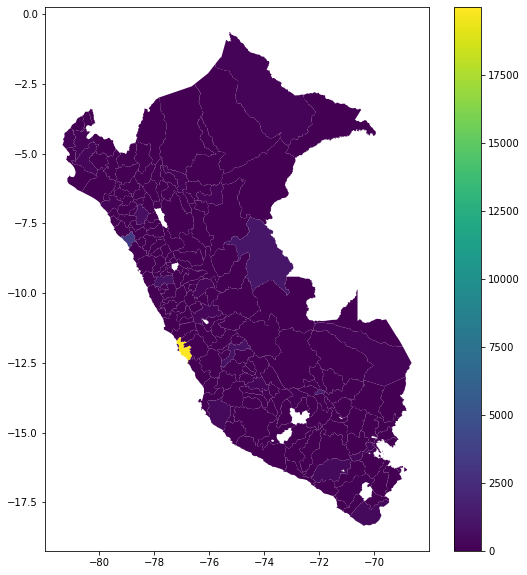

In [448]:
Dibujar_mapa(gdf, Gm_b_pro,'Cb', cType)

<Figure size 576x576 with 0 Axes>

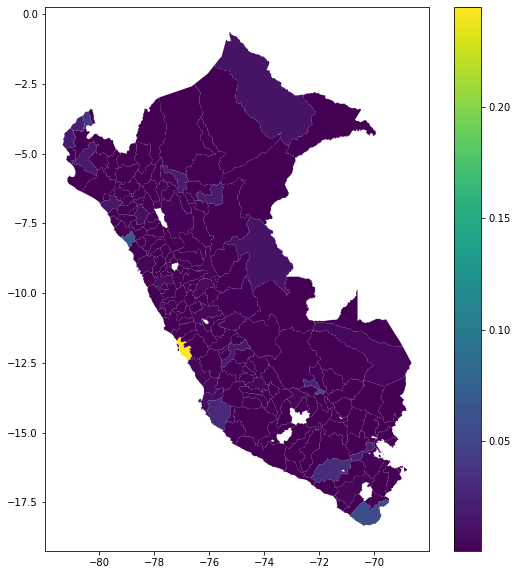

In [449]:
Dibujar_mapa(gdf, Gm_r_pro,'Cpr',  cType)

#### Distritos 

In [450]:
cType =  'dis'
Gm = ig.Graph.Read_Pajek("Input/grafoPeruDistritos.net")
directed=True
weight='weight'
name_at="name"


In [451]:
G_properties_dis, Gm_b_dis, Gm_r_dis = Calcular_medidas (Gm, directed,
                                             weight, name_at)

In [452]:
G_properties_dis.to_csv('Output/G_properties_{}.csv'.format(cType),
                    header=False)
G_properties_dis

,Variable,Value
0,Total vertices,1.094000e+03
1,Sending nodes,9.835466e+01
2,Receiving nodes,2.760512e+01
3,Degree,2.040300e+04
4,Connection density,1.706305e-02
5,Strength,1.966084e+08
6,Avg. path length,2.268403e+00
7,Number of triangles,3.282020e+05
8,Average triangles formed by an edge,9.000055e+02
9,Local average clustering coefficient,8.738344e-01


In [544]:
Gm_b_dis[:5]

[(289180.0, '150122'),
 (233061.0, '150140'),
 (78130.0, '150131'),
 (62713.0, '130101'),
 (39533.0, '120101')]

In [545]:
Gm_r_dis[:5]

[(0.11650076436437388, '150122'),
 (0.06295793806322283, '150131'),
 (0.04817582978174724, '130101'),
 (0.0431298524924681, '230101'),
 (0.028173180913731735, '240101')]

In [455]:
int(G_properties_dis.loc[G_properties_dis['Variable']=='Total vertices']['Value'])*5/100

54.7

In [456]:
cType =  'dis'
uMapLevel="Input/distritos/DISTRITOS.shp"
gdf = Leer_mapa(uMapLevel)

<Figure size 576x576 with 0 Axes>

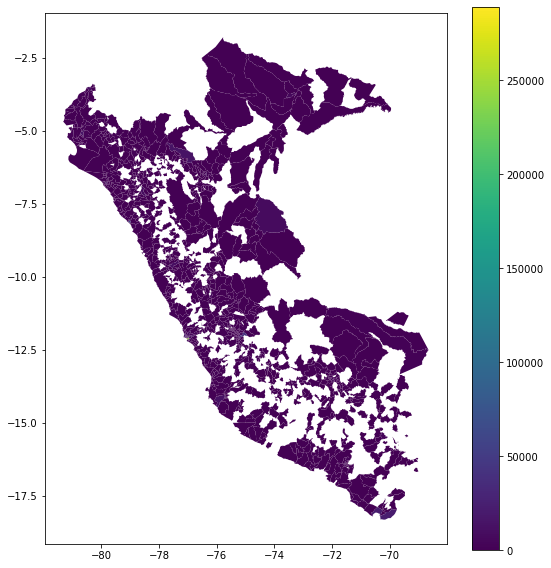

In [457]:
Dibujar_mapa(gdf, Gm_b_dis,'Cb', cType)

<Figure size 576x576 with 0 Axes>

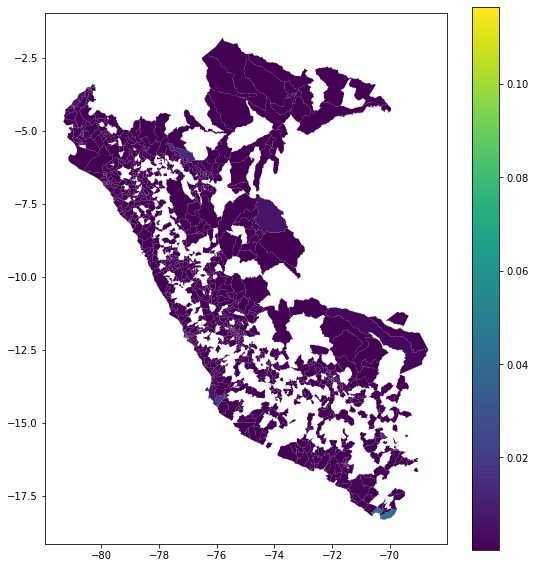

In [458]:
Dibujar_mapa(gdf, Gm_r_dis,'Cpr',  cType)